# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.

In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend, activations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
import scipy.misc
from imutils import paths
import numpy as np
import time
import math
import os
import cv2
import PIL

import warnings
warnings.filterwarnings('ignore')

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gas/venv_laptop_jupyter/lib/python3.6/site-packages/ten

Tensorflow Version: 1.14.0
Keras Version: 2.2.4-tf


In [2]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text, end="\r")

### Load dataset for testing

In [3]:
DATASET_PATH = os.getcwd() + "/dataset/corridor/test/corridor_05"

Genrate a list of image pathes for our testing

In [4]:
imagePaths = list(paths.list_images(DATASET_PATH))
imagePaths = sorted(imagePaths)
print("Size of the dataset: " + str(len(imagePaths)))

Size of the dataset: 8


Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [5]:
j = 0
images_lst = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (101, 101))
    images_lst.append(image)
    update_progress(j / len(imagePaths))
    j = j + 1.0
    
print(imagePaths)

['/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/0001.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/0002.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/0003.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/0004.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/img_00001.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/img_00002.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/img_00003.jpg', '/home/gas/UAV-II/JupyterNotebooks/CNN/dataset/corridor/test/corridor_05/img_00004.jpg']


Some examples of the Dataset

plt.figure(figsize=(15, 15))
plt.subplot(151)
plt.imshow(PIL.Image.fromarray(images_lst[0], 'RGB'))

plt.subplot(152)
plt.imshow(PIL.Image.fromarray(images_lst[int(len(images_lst)/4)], 'RGB'))
 
plt.subplot(153)
plt.imshow(PIL.Image.fromarray(images_lst[int(len(images_lst)/2)], 'RGB'))

plt.subplot(154)
plt.imshow(PIL.Image.fromarray(images_lst[(int(len(images_lst)/2) + int(len(images_lst)/4))], 'RGB'))

plt.subplot(155)
plt.imshow(PIL.Image.fromarray(images_lst[-1], 'RGB')) 

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [6]:
images_np = np.asarray(images_lst) / 255.0

### Restore model parameters
Recreate the exact same model, including weights and optimizer.

In [7]:
path = './checkpoints/corridor_weights00000177.h5'

model = tf.keras.models.load_model(path)

Change the activation layer for better interpretation of the CNN featurmap output with one of them:
* softmax <-
* elu 
* selu
* softplus
* softsign
* relu
* tanh
* sigmoid
* hard_sigmoid
* exponential
* linear


For more details look at: https://keras.io/activations/

### Inference

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [8]:
tf.test.is_gpu_available(cuda_only = True)

True

Generates output predictions for the input samples.
Computation is done in batches.

In [9]:
predictions = list()

for i in range(len(images_np)):
    prediction = model.predict(np.expand_dims(np.expand_dims(images_np[i],axis=0), axis=3),
                                   batch_size = None,
                                   verbose = 1,
                                   steps = None,
                                   max_queue_size = 10,
                                   workers = 1,
                                   use_multiprocessing = False)
    predictions.append(prediction)
    
predictions = np.asarray(predictions)

1/1 [==============================] - 0s 1ms/sample


Generate probabilities

Calculate yaw angle for the robot controller

In [10]:
yaw_angles = list()
for i in range(len(predictions)):
    left_propability = predictions[i][0][0]
    right_propability = predictions[i][0][2]

    propability = left_propability - right_propability
    yaw_angle = propability * 30
    yaw_angles.append(yaw_angle)

### Visualizing Results
Generate for each image an activation- and heatmap

In [11]:
heat_maps = []
activation_maps = []
j = 0
for i in range(len(predictions)):

    FIRST_ELEMENT = i
    prediction_vector_index = np.argmax(predictions[FIRST_ELEMENT])

    # This is the entry in the prediction vector
    model_output = model.output[:, prediction_vector_index]

    # The is the output feature map of the `conv2d_3` layer,
    # the last convolutional layer in CNN
    last_conv_layer = model.get_layer('conv2d_1')

    # This is the gradient of the activated class with regard to
    # the output feature map of `conv2d_3`
    grads = backend.gradients(model_output, last_conv_layer.output)[0]

    # This is a vector of shape (32,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = backend.mean(grads, axis=(0))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `conv2d_3`,
    # given a sample image
    iterate = backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of the corridor
    x = np.expand_dims(np.expand_dims(images_np[0], axis=0), axis=3)
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    print(pooled_grads_value.shape, conv_layer_output_value.shape)
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard one of to the left,right or forward class
    for i in range(32):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[:, :, i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    activation_maps.append(heatmap)

    # We use cv2 to load the original image
    #img = images_np[FIRST_ELEMENT]
    img = images_lst[FIRST_ELEMENT]
    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to a numpy array
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # BGR to RGB
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = PIL.Image.fromarray(np.uint8(heatmap * 0.4 + cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)))
    
    heat_maps.append(superimposed_img)
    update_progress(j / len(predictions))
    j = j + 1.0

Plot the results

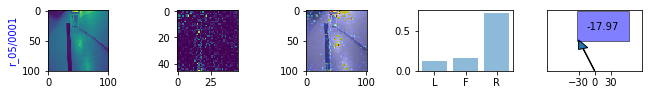

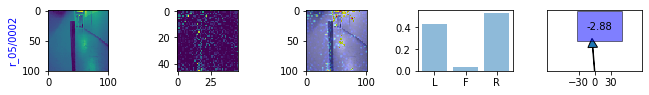

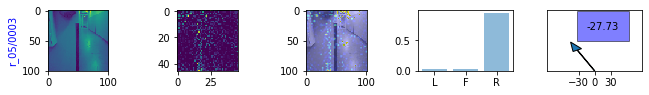

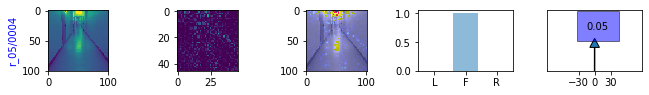

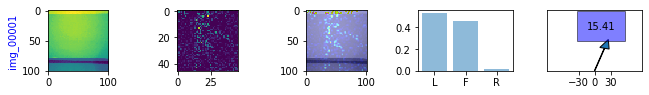

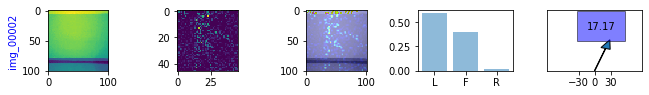

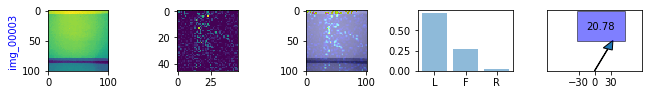

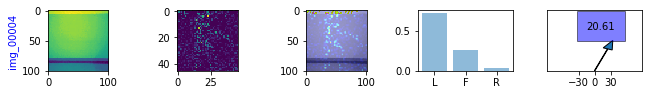

In [12]:
for i in range(len(yaw_angles)):
    yaw_angle = yaw_angles[i]
    prediction = predictions[i]
    inference_image = images_np[i]
    
    labels = ('L','F','R')
    LEFT = prediction[0][0]
    FORWARD = prediction[0][1]
    RIGHT = prediction[0][2]
    y_pos = np.arange(len(labels))

    plt.figure(figsize=(10, 1))
    plt.subplot(151)
    plt.imshow(inference_image)
    (plt.ylabel(str(imagePaths[i][-13:-4]))).set_color("blue")
    
    #plt.figure(figsize=(9, 2))
    plt.subplot(152)
    plt.imshow(activation_maps[i])
    
    #plt.figure(figsize=(9, 2))
    plt.subplot(153)
    plt.imshow(heat_maps[i])

    plt.subplot(154)
    plt.bar(y_pos, [LEFT, FORWARD, RIGHT], align='center', alpha=0.5)
    plt.xticks(y_pos, labels)

    ax = plt.subplot(155)
    ax.set_xlim([-90,90])
    ax.set_ylim([0,181])
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([-30,0,30])
    ax.text(-15, 125, str(round(yaw_angle,2)),
            bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
    plt.arrow(0, 0, 70 * math.sin(math.radians(yaw_angle)), 70 * math.cos(math.radians(yaw_angle)), shape="full",head_width=181*0.1, width=181*0.005)

    plt.subplots_adjust(top=0.92, 
                        bottom=0.08, 
                        left=0.10, 
                        right=0.95, 
                        hspace=0.25,
                        wspace=0.35)

    plt.show()

Generate a video with predictions. Turn on with (Cell -> Cell Type -> Code)

FileNotFoundError: [Errno 2] No such file or directory: './tmp/predictions/0.png'

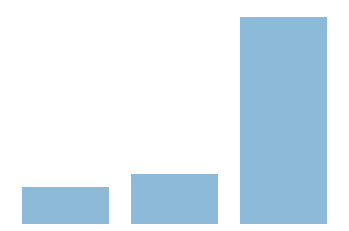

In [13]:
labels = ('L','F','R')
for i in range(len(predictions)):     
    prediction = predictions[i]
    fig = plt.figure()

    y_pos = np.arange(len(labels))
    plt.axis('off')
    LEFT = prediction[0][0] + 0.01
    FORWARD = prediction[0][1] + 0.01 
    RIGHT = prediction[0][2] +0.01
    plt.bar(y_pos, [LEFT, FORWARD, RIGHT], align='center', alpha=0.5)
    fig.savefig("./tmp/predictions/"+str(i)+".png", transparent=True)

In [ ]:
#j = 0
#images_lst_video = []
#for imagePath in imagePaths:
#    image = cv2.imread(imagePath)
#    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#    images_lst_video.append(image)

out = cv2.VideoWriter(str(DATASET_PATH[-11:])+".avi",cv2.VideoWriter_fourcc(*'DIVX'), 30, (960,720))

j = 0
for i in range(len(imagePaths)):
    bar = cv2.imread("./tmp/predictions/"+str(i)+".png")
    bar = np.asarray(bar)
    b2 = bar
    b1 = np.asarray(cv2.imread(imagePaths[i]))

    pos_v, pos_h = 720 - bar.shape[0], int(960/2 - bar.shape[1]/2)  # offset
    v_range1 = slice(max(0, pos_v), max(min(pos_v + b2.shape[0], b1.shape[0]), 0))
    h_range1 = slice(max(0, pos_h), max(min(pos_h + b2.shape[1], b1.shape[1]), 0))

    v_range2 = slice(max(0, -pos_v), min(-pos_v + b1.shape[0], b2.shape[0]))
    h_range2 = slice(max(0, -pos_h), min(-pos_h + b1.shape[1], b2.shape[1]))

    b1[v_range1, h_range1] = b2[v_range2, h_range2]  
    #vis = np.concatenate((b1[v_range1, h_range1], b2[v_range2, h_range2]), axis=0)
    out.write(b1)
    update_progress(j / len(imagePaths))
    j = j + 1.0
out.release()